# Explore differences between CEH-GEAR and HadUK-Grid

In [1]:
import numpy as np
import polars as pl
import geopandas as gpd
import xarray as xr
import rioxarray

import matplotlib.pyplot as plt
import scipy.stats


In [2]:
RAIN_COL = "rain_mm"

EASTING_RANGE = [279000, 324000] ## based on data I have. Entire easting range is: [279000, 388000]
NORTHING_RANGE = [271000, 308000] ## based on data I have. Entire northing range is: [271000, 341000]

# Load data

## Load CEH-GEAR

In [3]:
ceh_severn = xr.open_dataset('../../../CEH_GEAR/ceh_1km_severnregion_19700101_20230101.nc')
ceh_severn = ceh_severn.rename({'rainfall_amount': RAIN_COL})

ceh_abermule = ceh_severn.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))
ceh_abermule

<xarray.Dataset> Size: 1GB
Dimensions:   (time: 19358, y: 38, x: 46)
Coordinates:
  * x         (x) float64 368B 2.79e+05 2.8e+05 2.81e+05 ... 3.23e+05 3.24e+05
  * y         (y) float64 304B 2.71e+05 2.72e+05 2.73e+05 ... 3.07e+05 3.08e+05
  * time      (time) datetime64[ns] 155kB 1970-01-01 1970-01-02 ... 2022-12-31
Data variables:
    lat       (time, y, x) float64 271MB ...
    lon       (time, y, x) float64 271MB ...
    rain_mm   (time, y, x) float64 271MB ...
    min_dist  (time, y, x) float64 271MB ...
    crs       (time) int16 39kB ...
Attributes: (12/30)
    title:                CEH Gridded Estimates of Areal Rainfall (CEH - GEAR...
    institution:          CEH Wallingford - NERC
    source:               CEH - GEAR: dataset created using Natural Neighbour...
    description:          Daily rainfall 1km-gridded dataset created as part ...
    grid_mapping:         crs
    history:              Created Fri 2014-03-21 10:39:20
    ...                   ...
    version_comment:      The version number of each data file corresponds to...
    comment:              In line with standard UK convention, the rainfall o...
    reference:            Tanguy, M., Prosdocimi, I., Keller, V.D.J., Terry, ...
    licence:              Licensing conditions apply (datalicensing@ceh.ac.uk)
    summary:              The CEH-GEAR dataset contains 1-km grids of daily a...
    id:                   5dc179dc-f692-49ba-9326-a6893a503f6e

## Load HadUK-Grid

In [4]:
haduk_severn = xr.open_mfdataset(['../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_abermuleregion_19700101_19860831.nc',\
                '../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_abermuleregion_19860901_20041231.nc',\
                 '../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_abermuleregion_20050101_20221231.nc'])
haduk_severn = haduk_severn.rename({'rainfall': RAIN_COL, 'projection_x_coordinate': 'x', 'projection_y_coordinate': 'y'})
haduk_severn = haduk_severn.drop_vars(('latitude', 'longitude'))
haduk_severn['time'] = haduk_severn['time'].dt.floor(freq='D')

haduk_abermule = haduk_severn.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load HGHT grid

In [5]:
severn_hght = rioxarray.open_rasterio('../catchment_boundaries/HGHT_SEVERN_1km.tif')
severn_hght = severn_hght.sortby('y')
severn_hght = severn_hght.sel(band=1)

severn_hght = severn_hght.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load gauge metadata

In [6]:
## monthly gauges
severn_monthly_gauges = pl.read_csv('../gauge_data/mo_monthly_gauges_severn.csv', try_parse_dates=True)

In [7]:
# daily metadata
severn_metadata = pl.read_csv('../gauge_data/mo_severn_metadata.csv')
severn_metadata = severn_metadata.with_columns(
    pl.col("ID").is_in(severn_monthly_gauges['ID']).alias('IS_MONTHLY_GAUGE')
)

In [8]:
## Load gauge data (QC'd version)
severn_all_gauges = pl.read_csv('../gauge_data/mo_daily_severn_gauges.csv', try_parse_dates=True, new_columns=["gauge_id", "time", f'{RAIN_COL}_gauge', "mo_flag"])

# Load shapefiles

In [9]:
abermule_shp = gpd.read_file('../catchment_boundaries/Abermule/54014/54014.shp')
dolwen_shp = gpd.read_file('../catchment_boundaries/Dolwen/54080/54080.shp')
plynlimon_shp = gpd.read_file('../catchment_boundaries/Plynlimon Flume/54022/54022.shp')

# Shift grid

In [10]:
def coerse_data_into_haduk_format(data, offset, xrange, yrange):
    """
    Quick fix for coersing data to have same grid as HADUK.
    """
    data = data.assign_coords(x=(data['x'] + offset))
    data = data.assign_coords(y=(data['y'] + offset))
    data = data.sel(x=xrange, y=yrange)
    return data


In [11]:
ceh_abermule_shifted = coerse_data_into_haduk_format(ceh_abermule, offset=500, xrange=slice(*EASTING_RANGE), yrange=slice(*NORTHING_RANGE))

In [12]:
ceh_abermule_shifted['hght'] = severn_hght

# Functions to mask rainfall to catchments

In [13]:
def make_region_hght_clip(region_shp, hght_data):
    region_clip = hght_data.rio.clip(region_shp.geometry.values, region_shp.crs, drop=False, invert=False)
    return region_clip


def binarize_hght_clip(region_data):
    """
    Make binary mask of clipped region data data
    """
    return (region_data/region_data.where(region_data>0))


In [14]:
def mask_region_rainfall(rainfall_data, region_mask):
    return rainfall_data * binarize_hght_clip(region_mask).data


def mask_region_rainfall_by_hght(rainfall_data, region_hght, threshold):
    region_hght_mask = region_hght/region_hght.where(region_hght > threshold)
    return rainfall_data * region_hght_mask.data



In [15]:
abermule_hght = make_region_hght_clip(abermule_shp, hght_data=severn_hght)
dolwen_hght = make_region_hght_clip(dolwen_shp, hght_data=severn_hght)
plynlimon_hght = make_region_hght_clip(plynlimon_shp, hght_data=severn_hght)


# Get difference between HadUK to CEH-GEAR

In [16]:
ceh_abermule_shifted = ceh_abermule_shifted.sel(time=slice(haduk_abermule['time'].min(), haduk_abermule['time'].max()))

In [17]:
ceh_haduk_diff = ceh_abermule_shifted[RAIN_COL] - haduk_abermule[RAIN_COL]
diff_col_name = f'{RAIN_COL}_diff'
ceh_haduk_diff = ceh_haduk_diff.to_dataset(name=diff_col_name)
ceh_haduk_diff['hght'] = severn_hght
ceh_haduk_diff['min_dist'] = ceh_abermule_shifted['min_dist']

In [18]:
ceh_haduk_diff.load()

<xarray.Dataset> Size: 516MB
Dimensions:       (time: 19358, x: 45, y: 37)
Coordinates:
  * time          (time) datetime64[ns] 155kB 1970-01-01 ... 2022-12-31
  * x             (x) float64 360B 2.795e+05 2.805e+05 ... 3.225e+05 3.235e+05
  * y             (y) float64 296B 2.715e+05 2.725e+05 ... 3.065e+05 3.075e+05
    band          int64 8B 1
    spatial_ref   int64 8B 0
Data variables:
    rain_mm_diff  (time, y, x) float64 258MB -0.131 0.7493 ... 0.7603 0.08435
    hght          (y, x) int32 7kB 5496 5237 5032 5012 ... 1677 1080 787 697
    min_dist      (time, y, x) float64 258MB 4.269e+03 4.756e+03 ... 513.4

In [19]:
ceh_haduk_diff[diff_col_name].min(), ceh_haduk_diff[diff_col_name].max()

(<xarray.DataArray 'rain_mm_diff' ()> Size: 8B
 array(-65.64007871)
 Coordinates:
     band         int64 8B 1
     spatial_ref  int64 8B 0,
 <xarray.DataArray 'rain_mm_diff' ()> Size: 8B
 array(75.51704562)
 Coordinates:
     band         int64 8B 1
     spatial_ref  int64 8B 0)

In [20]:
catchments_shp_and_hght = {'Abermule': {'shp': abermule_shp, 'hght': abermule_hght}, \
    'Dolwen': {'shp': dolwen_shp, 'hght': dolwen_hght},\
    'Plynlimon Flume': {'shp': plynlimon_shp, 'hght': plynlimon_hght}}

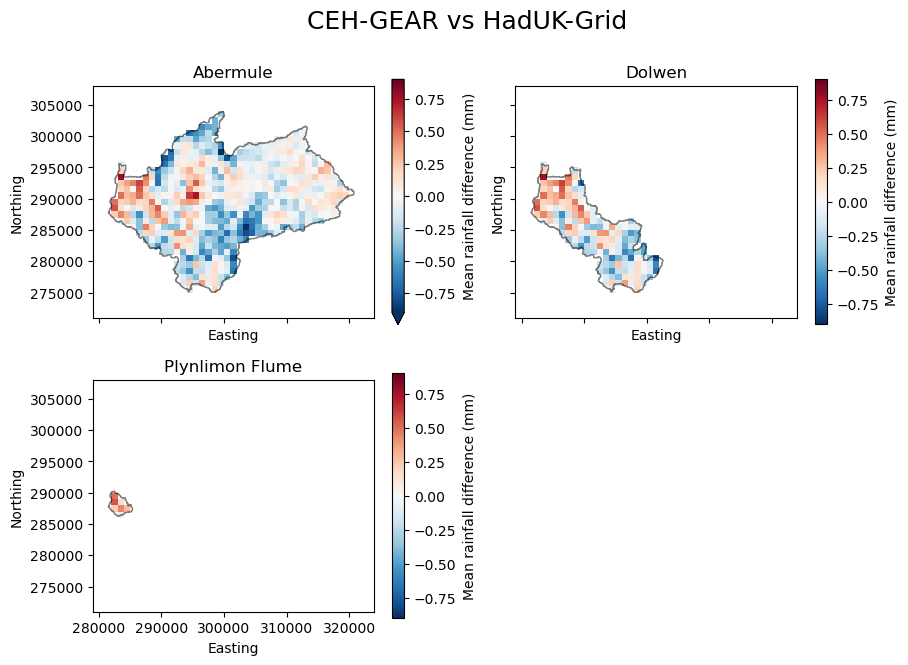

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

for ax, catchment in zip(axes.flatten(), catchments_shp_and_hght.keys()):
    mask_region_rainfall(ceh_haduk_diff, catchments_shp_and_hght[catchment]['hght']).mean('time')[f'{RAIN_COL}_diff'].plot(ax=ax, vmin=-0.9, vmax=0.9, cmap='RdBu_r', cbar_kwargs={'label': 'Mean rainfall difference (mm)'})
    catchments_shp_and_hght[catchment]['shp'].plot(ax=ax, facecolor='none', alpha=.5)
    ax.set_title(f"{catchment}")
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
axes[1][1].remove()
fig.suptitle("CEH-GEAR vs HadUK-Grid", size=18)
# fig.savefig('../figures/ceh_vs_haduk_differences/catchment_mask_vs_boundary.png', bbox_inches='tight', dpi=200)

# Explore differences between gridded datasets

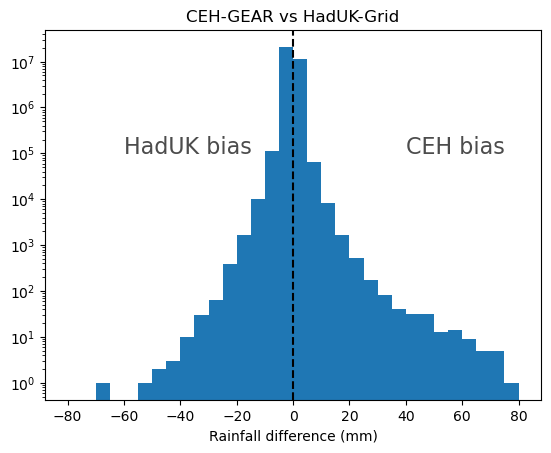

In [ ]:
fig, ax = plt.subplots(1)
ceh_haduk_diff[diff_col_name].plot(ax=ax, bins=np.arange(-80, 81, 5))
ax.set_yscale('log')
ax.set_title("CEH-GEAR vs HadUK-Grid")
ax.set_xlabel("Rainfall difference (mm)")
ax.text(s="CEH bias", x=40, y=100000, color='k', alpha=.7, size=16)
ax.text(s="HadUK bias", x=-60, y=100000, color='k', alpha=.7, size=16)
ax.axvline(0, linestyle='--', color='k')

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for ax, catchment in zip(axes.flatten(), catchments_shp_and_hght.keys()):
    region_mask_rainfall = mask_region_rainfall(ceh_haduk_diff, catchments_shp_and_hght[catchment]['hght'])
    region_mask_rainfall[diff_col_name].plot(ax=ax, bins=np.arange(-80, 81, 5))
    ax.set_yscale('log')
    ax.set_title(f"{catchment}\nCEH-GEAR vs HadUK-Grid")
    ax.set_xlabel("Rainfall difference (mm)")
    ax.set_ylabel('count')
    ax.text(s="CEH bias", x=20, y=100000, color='k', alpha=.7, size=16)
    ax.text(s="HadUK bias", x=-80, y=100000, color='k', alpha=.7, size=16)
    ax.axvline(0, linestyle='--', color='k')

axes[0][0].set_xlabel('')
axes[1][1].remove()
fig.subplots_adjust(hspace=.3)
# fig.savefig('../figures/ceh_vs_haduk_differences/catchment_hist_ceh_vs_haduk.png', bbox_inches='tight', dpi=200)

### Annual mean

In [68]:
annual_ceh_haduk_diff = ceh_haduk_diff.groupby('time.year').mean()

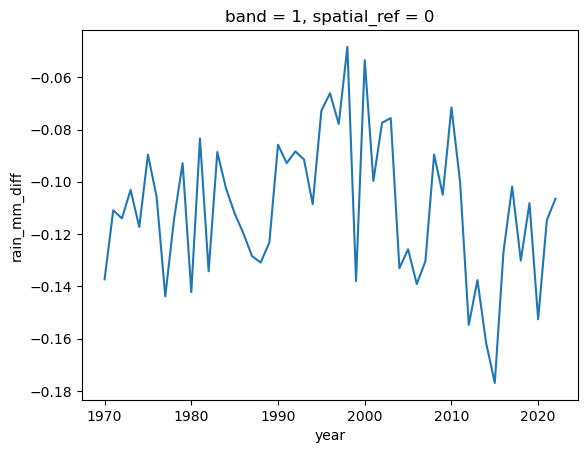

In [69]:
annual_ceh_haduk_diff[diff_col_name].mean(('x', 'y')).plot()

### by season

In [70]:
seasonal_ceh_haduk_diff = ceh_haduk_diff.groupby('time.season').mean()

In [71]:
abermule_mask_seasonal_rainfall = mask_region_rainfall(seasonal_ceh_haduk_diff, abermule_hght)


Text(0.5, 1, 'CEH-GEAR vs HadUK-Grid')

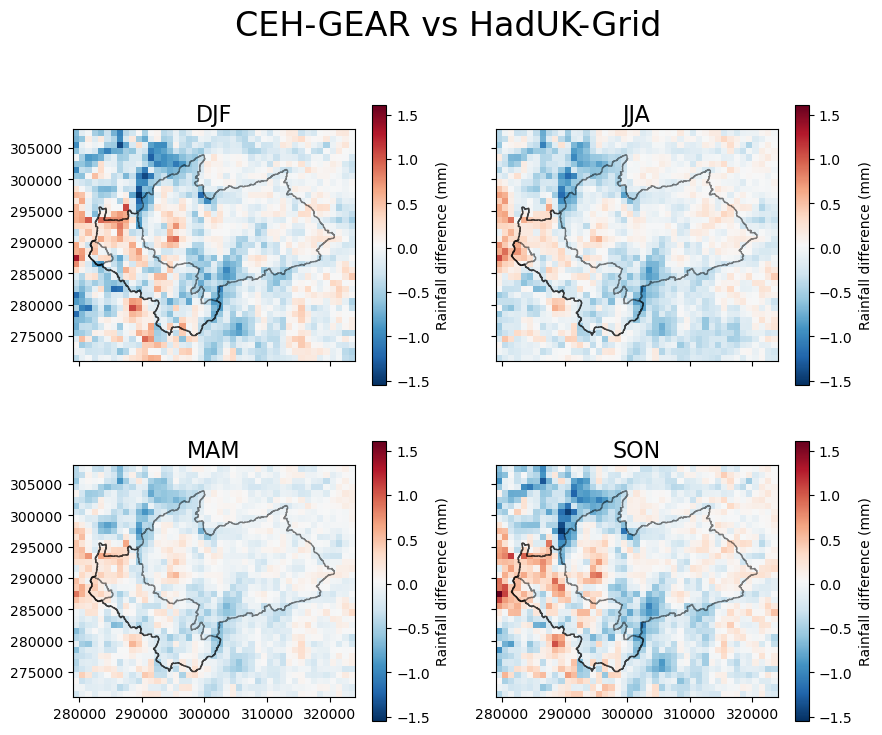

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for season, ax in zip(seasonal_ceh_haduk_diff['season'], axes.flatten()):
    seasonal_ceh_haduk_diff[diff_col_name].sel(season=season).plot(ax=ax, vmin=seasonal_ceh_haduk_diff[diff_col_name].min(), vmax=seasonal_ceh_haduk_diff[diff_col_name].max(),\
        cmap='RdBu_r', cbar_kwargs={'label':'Rainfall difference (mm)'})
    plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)
    abermule_shp.plot(ax=ax, facecolor='none', alpha=.5)
    dolwen_shp.plot(ax=ax, facecolor='none', alpha=.5)
    ax.set_title(str(season.data), size=16)
    ax.set_xlabel(''); ax.set_ylabel('')
fig.suptitle('CEH-GEAR vs HadUK-Grid', size=24, y=1)
# fig.savefig('../figures/ceh_vs_haduk_differences/ceh_vs_haduk_by_season.png', bbox_inches='tight', dpi=200)

### by month

In [29]:
monthly_ceh_haduk_diff = ceh_haduk_diff.groupby('time.month').mean()

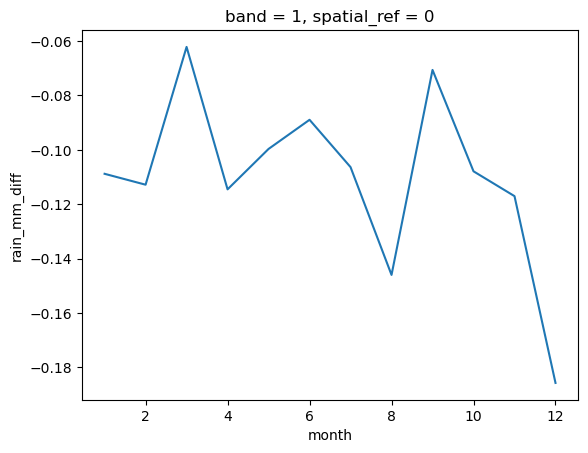

In [30]:
monthly_ceh_haduk_diff[diff_col_name].mean(('x', 'y')).plot()

## by decade

In [31]:
ceh_haduk_diff = ceh_haduk_diff.assign_coords(decade=(ceh_haduk_diff.time.dt.year // 10) * 10)
decadal_ceh_haduk_diff = ceh_haduk_diff.groupby("decade").mean()

Text(0, 0.5, 'Min distance to gauge')

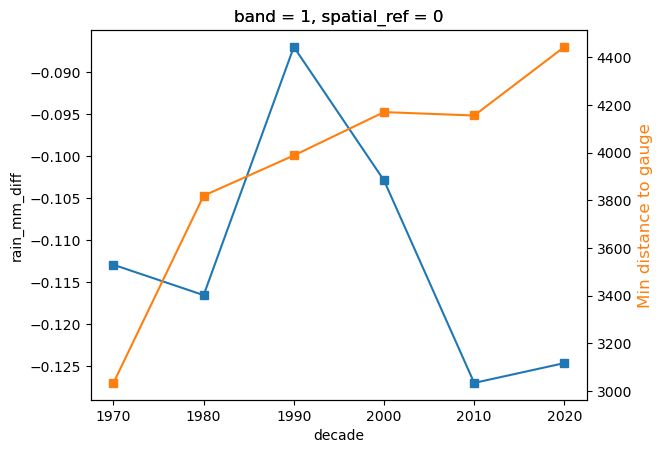

In [32]:
fig, ax = plt.subplots(1)
decadal_ceh_haduk_diff[diff_col_name].mean(('x', 'y')).plot(marker='s', ax=ax)
ax2 = ax.twinx()
decadal_ceh_haduk_diff['min_dist'].mean(('x', 'y')).plot(marker='s', ax=ax2, color='C1')
ax2.set_ylabel("Min distance to gauge", color='C1', size=12)

## topography vs rainfall

In [33]:
ceh_haduk_diff_mean = ceh_haduk_diff.mean('time')

In [34]:
def plot_scatter_w_regline(x, y, ax):
    linreg_coef = np.polyfit(x, y, deg=1)
    linreg_func = np.poly1d(linreg_coef)
    rval, pval = scipy.stats.pearsonr(x, y)
    ax.scatter(x, y)
    ax.plot(x, y, 'o', linreg_func(np.arange(x.min(), x.max())))
    ax.text(s=f'r={rval: .2f}\np={pval: .2f}', x=0, y=.8)
    return ax


def plot_quadrat_count_plot(x, y, ax,  num_quadrats=6):
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    y_max = max(y_max, abs(y_min))
    x_bins = np.linspace(x_min, x_max, num_quadrats + 1)
    y_bins = np.linspace(-y_max, y_max, num_quadrats + 1)

    # Count points in each quadrat
    quadrat_counts = np.zeros((num_quadrats, num_quadrats))
    for i in range(num_quadrats):
        for j in range(num_quadrats):
            in_x_range = (x >= x_bins[i]) & (x < x_bins[i+1])
            in_y_range = (y >= y_bins[j]) & (y < y_bins[j+1])
            quadrat_counts[i, j] = np.sum(in_x_range & in_y_range)

    for x_bin in x_bins:
        ax.axvline(x_bin, color='gray', linestyle='--', alpha=0.6)
    for y_bin in y_bins:
        ax.axhline(y_bin, color='gray', linestyle='--', alpha=0.6)

    # Annotate quadrat counts
    for i in range(num_quadrats):
        for j in range(num_quadrats):
            ax.text((x_bins[i] + x_bins[i+1]) / 2,
                    (y_bins[j] + y_bins[j+1]) / 2,
                    int(quadrat_counts[i, j]),
                    color='red', fontsize=12, ha='center', va='center')

    return ax

In [35]:
region_to_examine = 'Abermule'
region_diff_mean = mask_region_rainfall(ceh_haduk_diff_mean, catchments_shp_and_hght[region_to_examine]['hght'])

Text(0.5, 0.98, 'CEH-GEAR vs HadUK Grid rainfall vs gauge height')

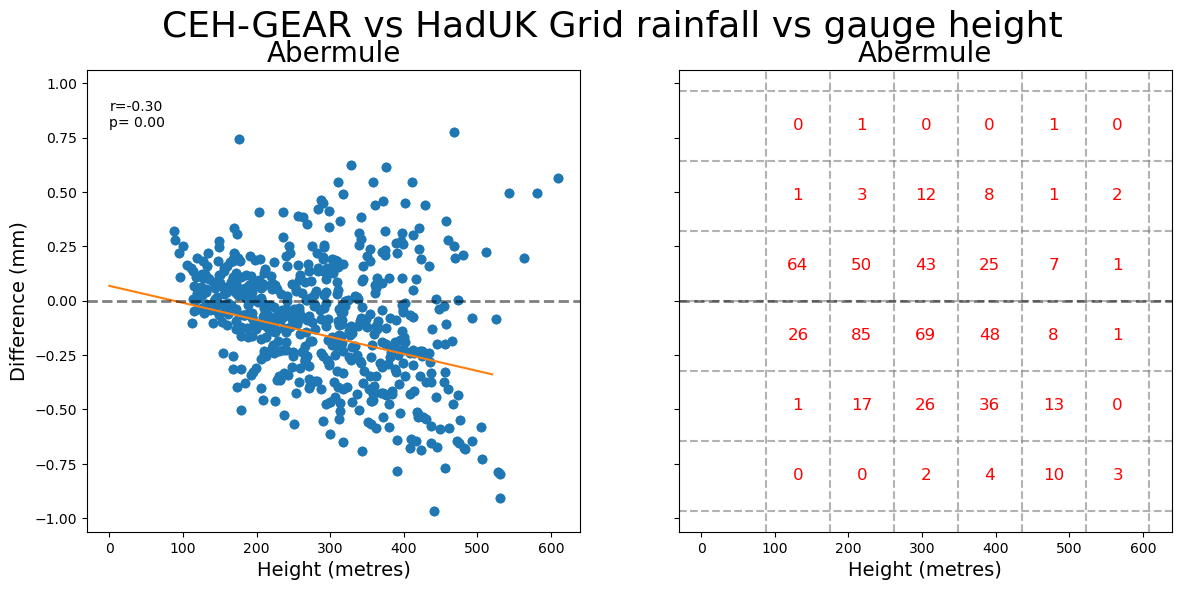

In [36]:
x = (region_diff_mean['hght']/10).data.flatten()
y = region_diff_mean['rain_mm_diff'].data.flatten()

## workaround required when using mask
x = x[np.isfinite(x)]
y = y[np.isfinite(y)]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
plot_scatter_w_regline(x, y, axes[0])
plot_quadrat_count_plot(x, y, axes[1])
for ax in axes:
    ax.set_title(f"{region_to_examine}", size=20)
    ax.set_xlabel("Height (metres)", size=14)
    ax.axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)

axes[0].set_ylabel("Difference (mm)", size=14)
fig.suptitle("CEH-GEAR vs HadUK Grid rainfall vs gauge height", size=26)
# fig.savefig('../figures/ceh_vs_haduk_differences/abermule_rain_vs_height_scatter.png', bbox_inches='tight', dpi=200)

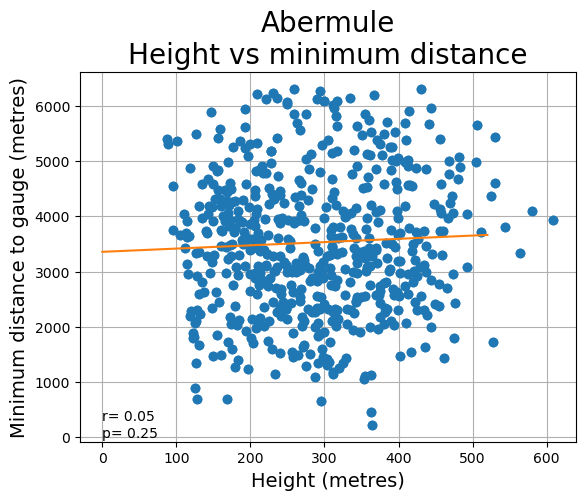

In [37]:
x = (region_diff_mean['hght']/10).data.flatten()
y = region_diff_mean['min_dist'].data.flatten()
## workaround required when using mask
x = x[np.isfinite(x)]
y = y[np.isfinite(y)]

fig, ax = plt.subplots(1)
plot_scatter_w_regline(x, y, ax)
ax.set_title(f"{region_to_examine}\nHeight vs minimum distance", size=20)
ax.set_xlabel("Height (metres)", size=14)
ax.set_ylabel("Minimum distance to gauge (metres)", size=14)
ax.grid()
# fig.savefig('../figures/ceh_vs_haduk_differences/abermule_height_vs_mindist_scatter.png', bbox_inches='tight', dpi=200)

In [38]:
print(f'Total of {int((ceh_haduk_diff_mean['rain_mm_diff'] > 0).sum().data)} grid cells where CEH > HadUK\nTotal of {int((ceh_haduk_diff_mean['rain_mm_diff'] < 0).sum().data)} grid cells where CEH < HadUK')

Total of 590 grid cells where CEH > HadUK
Total of 1075 grid cells where CEH < HadUK


Text(0.5, 0.98, 'CEH-GEAR vs HadUK Grid rainfall vs min distance')

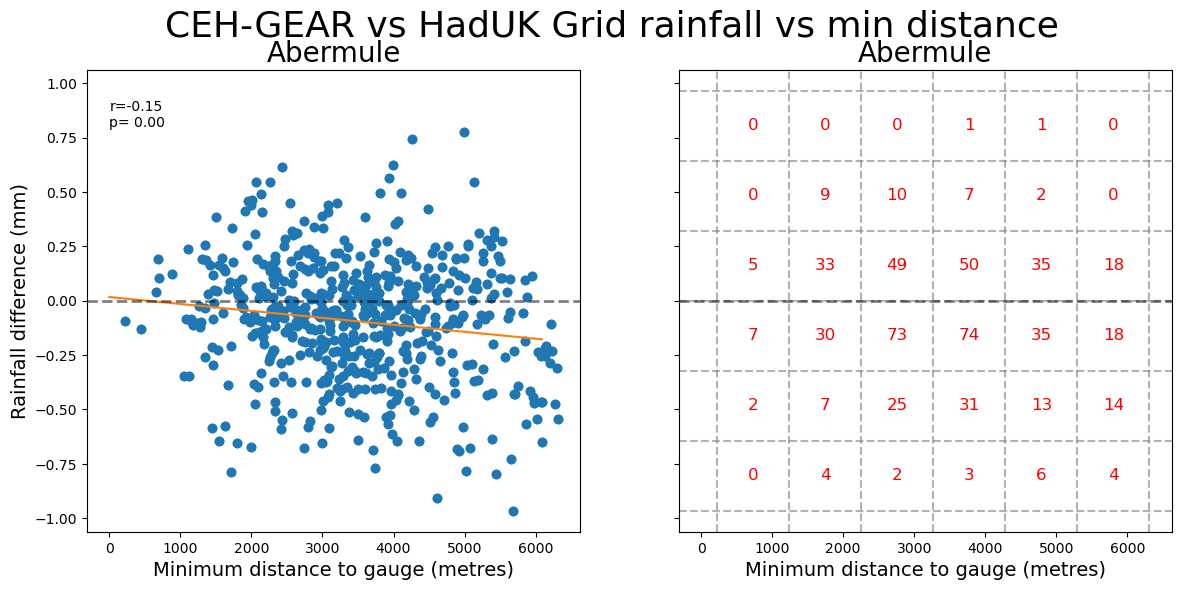

In [39]:
x = region_diff_mean['min_dist'].data.flatten()
y = region_diff_mean['rain_mm_diff'].data.flatten()

## workaround required when using mask
x = x[np.isfinite(x)]
y = y[np.isfinite(y)]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
plot_scatter_w_regline(x, y, axes[0])
plot_quadrat_count_plot(x, y, axes[1])
for ax in axes:
    ax.set_title(f"{region_to_examine}", size=20)
    ax.set_xlabel("Minimum distance to gauge (metres)", size=14)
    ax.axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)

axes[0].set_ylabel("Rainfall difference (mm)", size=14)
fig.suptitle("CEH-GEAR vs HadUK Grid rainfall vs min distance", size=26)

# fig.savefig('../figures/ceh_vs_haduk_differences/abermule_rainfall_vs_mindist_scatter.png', bbox_inches='tight', dpi=200)

## by season

In [40]:
abermule_mask_seasonal_rainfall = mask_region_rainfall(seasonal_ceh_haduk_diff, abermule_hght)


Text(0.5, 1, 'CEH vs HadUK vs Height')

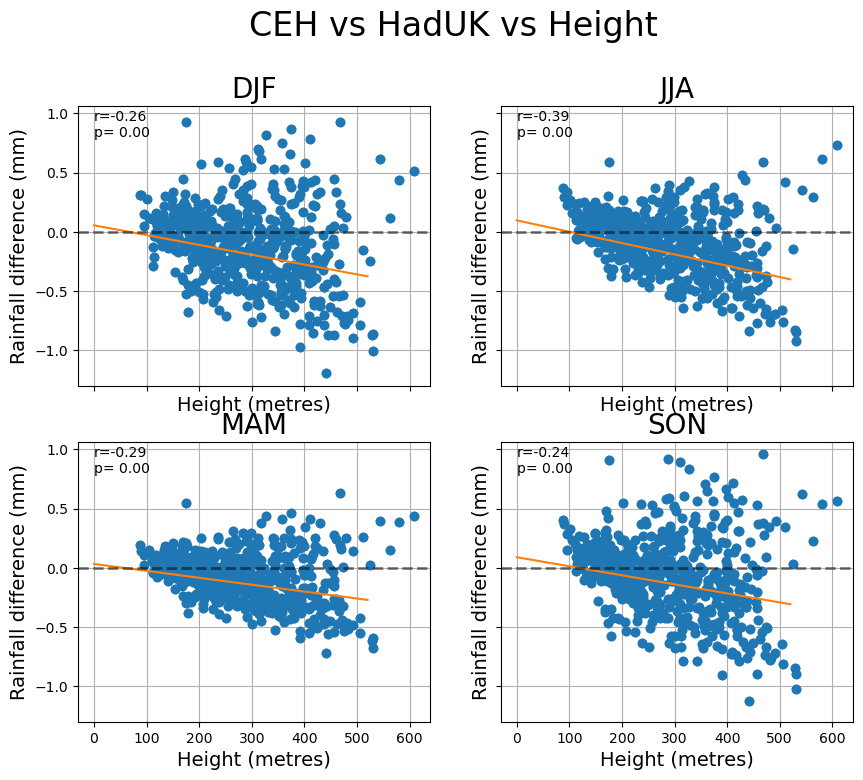

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
for season, ax in zip(abermule_mask_seasonal_rainfall['season'], axes.flatten()):
    x = (abermule_mask_seasonal_rainfall.sel(season=season)['hght']/10).data.flatten()
    y = abermule_mask_seasonal_rainfall.sel(season=season)['rain_mm_diff'].data.flatten()

    ## workaround required when using mask
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]

    ax = plot_scatter_w_regline(x, y, ax)
    # plot_quadrat_count_plot(x, y, ax)
    ax.set_title(str(season.data), size=20)
    ax.set_xlabel("Height (metres)", size=14)
    ax.set_ylabel("Rainfall difference (mm)", size=14)
    ax.axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)

    ax.grid()
fig.suptitle('CEH vs HadUK vs Height', size=24, y=1)